# Discriminative Project Milestone #2

#### Team Members:
Parth Saraykar

Novia Dsilva

Sanika Choudhari

Sailee Choudhari

In [ ]:
# ==============================================================================
# COMPLETE GRID-BASED CELEBRITY DETECTION DATASET
# ==============================================================================
# This creates composite images with multiple celebrities and trains YOLOv8
# to detect and identify each person in the image.

from pathlib import Path
import random, json, shutil
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
import yaml

# ============== CONFIGURATION ==============
SOURCE_ROOT = "/content/drive/MyDrive/Celebrity Image Subsets"  #  per-celeb folders
DATASET_ROOT = "/content/drive/MyDrive/celeba-det-grids"       # Output dataset
IMG_SIZE = 640                                                  # Square canvas size
GRID = (2, 2)                                                   # Grid layout (rows, cols)
N_TRAIN, N_VAL, N_TEST = 800, 200, 200                         # Composites per split
SEED = 42

random.seed(SEED)

# ============== STEP 1: SETUP FOLDERS ==============
print("Step 1: Creating folder structure...")
for p in ["images/train", "images/val", "images/test",
          "labels/train", "labels/val", "labels/test"]:
    Path(DATASET_ROOT, p).mkdir(parents=True, exist_ok=True)

# ============== STEP 2: BUILD CLASS LIST ==============
print("\nStep 2: Building class list...")
classes_list = sorted([p.name for p in Path(SOURCE_ROOT).iterdir() if p.is_dir()])
cls_to_idx = {c: i for i, c in enumerate(classes_list)}

# Save class mapping (CRITICAL for inference later)
Path(DATASET_ROOT, "id_map.json").write_text(json.dumps(classes_list, indent=2))
print(f"Found {len(classes_list)} celebrities")
print("First 10:", classes_list[:10])

# ============== STEP 3: COLLECT SOURCE IMAGES ==============
print("\nStep 3: Collecting source images...")
pairs = []
exts = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")
for celeb in classes_list:
    celeb_dir = Path(SOURCE_ROOT, celeb)
    for ext in exts:
        for p in celeb_dir.glob(ext):
            pairs.append((str(p), celeb))

print(f"Total source images: {len(pairs)}")

# ============== STEP 4: SPLIT DATA ==============
print("\nStep 4: Splitting data (stratified by celebrity)...")
labels = [c for _, c in pairs]
train_pairs, test_pairs = train_test_split(
    pairs, test_size=0.15, stratify=labels, random_state=SEED
)
train_labels = [c for _, c in train_pairs]
train_pairs, val_pairs = train_test_split(
    train_pairs, test_size=0.1765, stratify=train_labels, random_state=SEED
)

print(f"Train: {len(train_pairs)} | Val: {len(val_pairs)} | Test: {len(test_pairs)}")

# ============== STEP 5: GRID GENERATION FUNCTIONS ==============
W = H = IMG_SIZE
gw, gh = GRID
tile_w, tile_h = W // gw, H // gh
per_grid = gw * gh

def group_by_celeb(pairs):
    """Group image paths by celebrity ID"""
    d = defaultdict(list)
    for p, c in pairs:
        d[c].append(p)
    return d

def pick_k_distinct_ids(group_dict, k):
    """Pick k different celebrities that have available images"""
    pool = [cid for cid, lst in group_dict.items() if len(lst) > 0]
    if len(pool) < k:
        return None
    return random.sample(pool, k)

def pop_image_for_id(group_dict, cid):
    """Get and remove one random image for a celebrity"""
    lst = group_dict[cid]
    if not lst:
        return None
    i = random.randrange(len(lst))
    return lst.pop(i)

def write_yolo_label(txt_path, cls_idx, x, y, w, h, W, H):
    """Write one bounding box in YOLO format (normalized)"""
    xc = (x + w/2) / W
    yc = (y + h/2) / H
    ww = w / W
    hh = h / H
    with open(txt_path, "a") as f:
        f.write(f"{cls_idx} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}\n")

# ============== STEP 6: GENERATE GRIDS ==============
print("\nStep 6: Generating grid composites...")

groups = {
    "train": group_by_celeb(train_pairs),
    "val": group_by_celeb(val_pairs),
    "test": group_by_celeb(test_pairs),
}

def make_grids(split_name, target_count):
    """Create grid composites for a data split"""
    out_img = Path(DATASET_ROOT, "images", split_name)
    out_lab = Path(DATASET_ROOT, "labels", split_name)
    gdict = groups[split_name]

    made, tries = 0, 0
    print(f"\n[{split_name.upper()}] Generating {target_count} grids...")

    while made < target_count and tries < target_count * 20:
        tries += 1

        # Pick distinct celebrities for this grid
        ids = pick_k_distinct_ids(gdict, per_grid)
        if not ids:
            print(f"  Warning: Ran out of celebrity combinations at {made} grids")
            break

        # Get one image per celebrity
        picks = []
        for cid in ids:
            p = pop_image_for_id(gdict, cid)
            if p is None:
                picks = []
                break
            picks.append((p, cid))

        if len(picks) != per_grid:
            continue

        # Create grid canvas
        canvas = Image.new("RGB", (W, H), (0, 0, 0))
        labels = []

        for i, (src, cid) in enumerate(picks):
            try:
                # Load and resize image
                im = Image.open(src).convert("RGB").resize((tile_w, tile_h))

                # Calculate position in grid
                gx, gy = i % gw, i // gw
                x0, y0 = gx * tile_w, gy * tile_h

                # Paste into canvas
                canvas.paste(im, (x0, y0))

                # Record label
                labels.append((cls_to_idx[cid], x0, y0, tile_w, tile_h))

            except Exception as e:
                print(f"  Error loading {src}: {e}")
                picks = []
                break

        if len(picks) != per_grid:
            continue

        # Save composite image and labels
        name = f"grid_{split_name}_{made:05d}"
        canvas.save(out_img / f"{name}.jpg", quality=95)

        lab_path = out_lab / f"{name}.txt"
        if lab_path.exists():
            lab_path.unlink()

        for cls_idx, x, y, w, h in labels:
            write_yolo_label(lab_path, cls_idx, x, y, w, h, W, H)

        made += 1

        if made % 50 == 0:
            print(f"  Progress: {made}/{target_count} grids created")

    print(f"[{split_name.upper()}] Completed: {made} grids (attempts: {tries})")
    return made

# Generate all splits
train_count = make_grids("train", N_TRAIN)
val_count = make_grids("val", N_VAL)
test_count = make_grids("test", N_TEST)

# ============== STEP 7: CREATE DATA.YAML ==============
print("\nStep 7: Writing data.yaml configuration...")

data_yaml = {
    "path": DATASET_ROOT,
    "train": "images/train",
    "val": "images/val",
    "test": "images/test",
    "nc": len(classes_list),
    "names": classes_list
}

with open(Path(DATASET_ROOT, "data.yaml"), "w") as f:
    yaml.safe_dump(data_yaml, f, default_flow_style=False)

print(f"Saved to: {Path(DATASET_ROOT, 'data.yaml')}")

# ============== STEP 8: VERIFICATION ==============
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Dataset location: {DATASET_ROOT}")
print(f"Number of celebrities: {len(classes_list)}")
print(f"Grid layout: {gw}x{gh} ({per_grid} celebrities per image)")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"\nData splits:")
print(f"  Train: {train_count} grids")
print(f"  Val:   {val_count} grids")
print(f"  Test:  {test_count} grids")
print(f"\nReady for YOLOv8 training!")
print("="*60)

Step 1: Creating folder structure...

Step 2: Building class list...
Found 46 celebrities
First 10: ['images_7904_', 'images__10046_', 'images__10173_', 'images__1158_', 'images__1499_', 'images__1852_', 'images__1964_', 'images__228_', 'images__2425_', 'images__2463_']

Step 3: Collecting source images...
Total source images: 1493

Step 4: Splitting data (stratified by celebrity)...
Train: 1045 | Val: 224 | Test: 224

Step 6: Generating grid composites...

[TRAIN] Generating 800 grids...
  Progress: 50/800 grids created
  Progress: 100/800 grids created
  Progress: 150/800 grids created
  Progress: 200/800 grids created
  Progress: 250/800 grids created
[TRAIN] Completed: 261 grids (attempts: 262)

[VAL] Generating 200 grids...
  Progress: 50/200 grids created
[VAL] Completed: 53 grids (attempts: 54)

[TEST] Generating 200 grids...
  Progress: 50/200 grids created
[TEST] Completed: 54 grids (attempts: 55)

Step 7: Writing data.yaml configuration...
Saved to: /content/drive/MyDrive/cel

In [ ]:
# ==============================================================================
# YOLOv8 TRAINING FOR GRID-BASED CELEBRITY DETECTION
# ==============================================================================

!pip install ultralytics

from IPython.display import Image, display
from pathlib import Path
from ultralytics import YOLO
import json

# ============== CONFIGURATION ==============
DATASET_ROOT = "/content/drive/MyDrive/celeba-det-grids"
MODEL_SIZE = "yolov8s.pt"
EPOCHS = 50
BATCH_SIZE = 16
IMG_SIZE = 640

# ============== VERIFY DATASET ==============
print("Verifying dataset...")
data_yaml = Path(DATASET_ROOT, "data.yaml")
id_map = Path(DATASET_ROOT, "id_map.json")

assert data_yaml.exists(), f"data.yaml not found at {data_yaml}"
assert id_map.exists(), f"id_map.json not found at {id_map}"

classes = json.loads(id_map.read_text())
print(f"Dataset ready with {len(classes)} celebrity classes")

# Check image counts
train_imgs = list(Path(DATASET_ROOT, "images/train").glob("*.jpg"))
val_imgs = list(Path(DATASET_ROOT, "images/val").glob("*.jpg"))
test_imgs = list(Path(DATASET_ROOT, "images/test").glob("*.jpg"))

print(f"\nImage counts:")
print(f"  Train: {len(train_imgs)}")
print(f"  Val:   {len(val_imgs)}")
print(f"  Test:  {len(test_imgs)}")

if len(train_imgs) == 0:
    raise ValueError("No training images found! Run the grid generation script first.")

# ============== INITIALIZE MODEL ==============
print(f"\nInitializing {MODEL_SIZE}...")
model = YOLO(MODEL_SIZE)

# ============== TRAIN ==============
print("\nStarting training...")
print(f"Epochs: {EPOCHS} | Batch: {BATCH_SIZE} | Image size: {IMG_SIZE}")
print("-" * 60)

results = model.train(
    data=str(data_yaml),
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,

    # Augmentation settings (optimized for faces)
    degrees=5.0,        # Small rotations
    translate=0.10,     # 10% translation
    scale=0.5,          # Multi-scale (0.5 to 1.5)
    shear=2.0,          # Slight shearing
    fliplr=0.5,         # Horizontal flip
    flipud=0.0,         # No vertical flip (faces are upright)

    # Color augmentation
    hsv_h=0.015,        # Hue
    hsv_s=0.7,          # Saturation
    hsv_v=0.4,          # Value/brightness

    # Advanced augmentation
    mosaic=0.8,         # Mosaic augmentation (good for multi-object)
    mixup=0.1,          # Mixup augmentation
    copy_paste=0.0,     # Copy-paste (disabled)

    # Training settings
    patience=20,        # Early stopping patience
    save=True,
    save_period=5,      # Save checkpoint every 5 epochs

    # Output
    project=str(Path(DATASET_ROOT, "runs")),
    name="celeb_detection",
    exist_ok=True
)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

# ============== VALIDATION ==============
print("\nRunning validation on best model...")
best_model_path = Path(DATASET_ROOT, "runs/celeb_detection/weights/best.pt")

if best_model_path.exists():
    best_model = YOLO(str(best_model_path))
    metrics = best_model.val(data=str(data_yaml))

    print(f"\nValidation Metrics:")
    print(f"  mAP50: {metrics.box.map50:.4f}")
    print(f"  mAP50-95: {metrics.box.map:.4f}")
    print(f"  Precision: {metrics.box.mp:.4f}")
    print(f"  Recall: {metrics.box.mr:.4f}")
else:
    print(f"Best model not found at {best_model_path}")

# ============== TEST PREDICTIONS ==============
print("\n" + "="*60)
print("Running predictions on test set...")
print("="*60)

if best_model_path.exists():
    test_results = best_model.predict(
        source=str(Path(DATASET_ROOT, "images/test")),
        save=True,
        save_txt=True,
        save_conf=True,
        project=str(Path(DATASET_ROOT, "predictions")),
        name="test_results",
        exist_ok=True
    )

    print(f"\nPredictions saved to: {Path(DATASET_ROOT, 'predictions/test_results')}")
    print("Check the folder for annotated images!")

print("\n" + "="*60)
print("ALL DONE!")
print("="*60)
print(f"\nBest model weights: {best_model_path}")
print(f"Training logs: {Path(DATASET_ROOT, 'runs/celeb_detection')}")
print(f"Test predictions: {Path(DATASET_ROOT, 'predictions/test_results')}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Verifying dataset...
Dataset ready with 46 celebrity classes

Image counts:
  Train: 261
  Val:   53
  Test:  54

Initializing yolov8s.pt...

Starting training...
Epochs: 50 | Batch: 16 | Image size: 640
------------------------------------------------------------
Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=Fa

## DETECTING CELEBRITIES IN NEW IMAGES

In [ ]:
from pathlib import Path
from ultralytics import YOLO
import json
from PIL import Image, ImageDraw, ImageFont
import cv2

# ============== CONFIGURATION ==============
DATASET_ROOT = "/content/drive/MyDrive/celeba-det-grids"
MODEL_PATH = f"{DATASET_ROOT}/runs/celeb_detection/weights/best.pt"
ID_MAP_PATH = f"{DATASET_ROOT}/id_map.json"

# Inference settings
CONFIDENCE_THRESHOLD = 0.25  # Minimum confidence to show detection
IOU_THRESHOLD = 0.45         # NMS threshold

# ============== LOAD MODEL AND CLASS NAMES ==============
print("Loading model and class mapping...")
model = YOLO(MODEL_PATH)

# Load celebrity ID mapping
with open(ID_MAP_PATH, 'r') as f:
    id_to_celeb = json.load(f)

print(f"Model loaded with {len(id_to_celeb)} celebrity classes")

# ============== INFERENCE FUNCTION ==============
def detect_celebrities(image_path, save_path=None, show_labels=True):
    """
    Detect celebrities in an image

    Args:
        image_path: Path to input image
        save_path: Optional path to save annotated image
        show_labels: Whether to show celebrity names on detections

    Returns:
        List of detections: [(celeb_name, confidence, bbox), ...]
    """
    # Run inference
    results = model.predict(
        source=image_path,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )[0]

    detections = []

    # Process results
    if len(results.boxes) > 0:
        for box in results.boxes:
            # Extract info
            cls_idx = int(box.cls[0])
            conf = float(box.conf[0])
            x1, y1, x2, y2 = box.xyxy[0].tolist()

            # Get celebrity name
            celeb_name = id_to_celeb[cls_idx]

            detections.append({
                'celebrity': celeb_name,
                'confidence': conf,
                'bbox': [x1, y1, x2, y2]
            })

    if save_path and show_labels:
        img = Image.open(image_path).convert('RGB')
        draw = ImageDraw.Draw(img)

        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)
        except:
            font = ImageFont.load_default()

        for det in detections:
            x1, y1, x2, y2 = det['bbox']
            celeb = det['celebrity']
            conf = det['confidence']

            # Draw box
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)

            # Draw label with background
            label = f"{celeb}: {conf:.2f}"
            bbox = draw.textbbox((x1, y1 - 20), label, font=font)
            draw.rectangle(bbox, fill='red')
            draw.text((x1, y1 - 20), label, fill='white', font=font)

        img.save(save_path)
        print(f"Annotated image saved to: {save_path}")

    return detections

# ============== BATCH INFERENCE ==============
def batch_inference(image_dir, output_dir):
    """
    Run inference on all images in a directory

    Args:
        image_dir: Directory containing images
        output_dir: Directory to save results
    """
    image_dir = Path(image_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Find all images
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        image_files.extend(image_dir.glob(ext))

    print(f"Processing {len(image_files)} images...")

    all_results = {}

    for img_path in image_files:
        print(f"\nProcessing: {img_path.name}")

        # Run detection
        detections = detect_celebrities(
            str(img_path),
            save_path=str(output_dir / f"annotated_{img_path.name}"),
            show_labels=True
        )
        if detections:
            print(f"  Found {len(detections)} celebrities:")
            for det in detections:
                print(f"    - {det['celebrity']}: {det['confidence']:.3f}")
        else:
            print("  No celebrities detected")

        all_results[img_path.name] = detections

    results_json = output_dir / "detection_results.json"
    with open(results_json, 'w') as f:
        json.dump(all_results, f, indent=2)

    print(f"\n{'='*60}")
    print(f"All results saved to: {output_dir}")
    print(f"JSON results: {results_json}")
    print(f"{'='*60}")

# ============== EXAMPLE USAGE ==============

# Single image inference
print("\n" + "="*60)
print("EXAMPLE 1: Single Image Inference")
print("="*60)

# Use a test image
test_image = next(Path(DATASET_ROOT, "images/test").glob("*.jpg"))
output_path = Path(DATASET_ROOT, "inference_example.jpg")

detections = detect_celebrities(
    str(test_image),
    save_path=str(output_path),
    show_labels=True
)

print(f"\nDetections in {test_image.name}:")
for det in detections:
    print(f"  {det['celebrity']}: {det['confidence']:.3f} @ {det['bbox']}")

# Batch inference on test set
print("\n" + "="*60)
print("EXAMPLE 2: Batch Inference")
print("="*60)

batch_inference(
    image_dir=f"{DATASET_ROOT}/images/test",
    output_dir=f"{DATASET_ROOT}/inference_results"
)

print("\n Inference complete! Check the output folders for results.")

Loading model and class mapping...
Model loaded with 46 celebrity classes

EXAMPLE 1: Single Image Inference
Annotated image saved to: /content/drive/MyDrive/celeba-det-grids/inference_example.jpg

Detections in grid_test_00000.jpg:
  images__3401_: 0.992 @ [0.0, 0.0, 321.93536376953125, 321.509521484375]
  images__487_: 0.920 @ [0.197967529296875, 319.52301025390625, 321.2680969238281, 640.0]
  images__10046_: 0.506 @ [318.81451416015625, 319.29364013671875, 639.7821044921875, 639.8594360351562]
  images__8968_: 0.287 @ [318.351318359375, 318.86981201171875, 639.9427490234375, 640.0]

EXAMPLE 2: Batch Inference
Processing 54 images...

Processing: grid_test_00000.jpg
Annotated image saved to: /content/drive/MyDrive/celeba-det-grids/inference_results/annotated_grid_test_00000.jpg
  Found 4 celebrities:
    - images__3401_: 0.992
    - images__487_: 0.920
    - images__10046_: 0.506
    - images__8968_: 0.287

Processing: grid_test_00001.jpg
Annotated image saved to: /content/drive/MyDr

## Testing

The concatenated image(with many celeb in the picture) is passed to the model, it will first get the celebrity ID for the Celebrities present in the image along with the name

In [ ]:
# First, looking at all celebrities in the image
results = model.predict(source="/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00021.jpg", conf=0.25, verbose=False)[0]

print("All celebrities detected:")
for box in results.boxes:
    cls_idx = int(box.cls[0])
    print(f"ID: {cls_idx}, Name: {id_to_celeb[cls_idx]}")

All celebrities detected:
ID: 4, Name: images__1499_
ID: 43, Name: images__9256_
ID: 0, Name: images_7904_
ID: 24, Name: images__4304_


After we have the ID, we check how confident the model is to locate the celebrity in the image

In [11]:
#!pip install ultralytics

from ultralytics import YOLO
import json

# Load model
model = YOLO("/content/drive/MyDrive/celeba-det-grids/runs/celeb_detection/weights/best.pt")
with open("/content/drive/MyDrive/celeba-det-grids/id_map.json") as f:
    id_to_celeb = json.load(f)

def detect_celebrity_by_id(image_path, celebrity_id):
    results = model.predict(source=image_path, conf=0.25, verbose=False)[0]

    for box in results.boxes:
        if int(box.cls[0]) == celebrity_id:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            return {
                'id': celebrity_id,
                'name': id_to_celeb[celebrity_id],
                'confidence': float(box.conf[0]),
                'bbox': [x1, y1, x2, y2]
            }
    return None

# Usage
result = detect_celebrity_by_id("/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00021.jpg", celebrity_id=43)
print(result)

{'id': 43, 'name': 'images__9256_', 'confidence': 0.9921016097068787, 'bbox': [0.197265625, 318.6729736328125, 321.006103515625, 640.0]}


So, here we have passed the concatenated image from the drive with a certain celebrity ID which we want the model to detect in that image with a bounding box

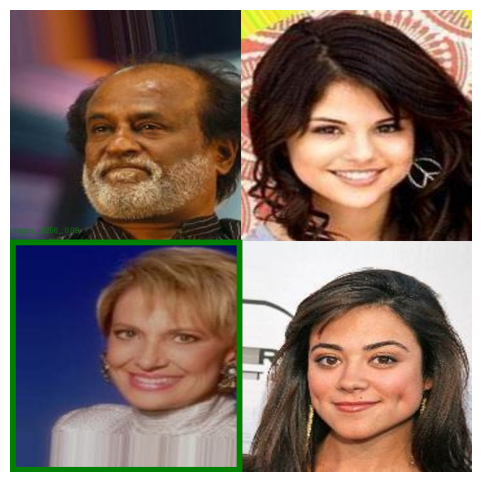

{'id': 43, 'name': 'images__9256_', 'confidence': 0.9921016097068787, 'bbox': [0.197265625, 318.6729736328125, 321.006103515625, 640.0]}


In [12]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00021.jpg"
result = detect_celebrity_by_id(image_path, celebrity_id=43)

# Load image
img = Image.open(image_path).convert('RGB')

# Draw box if celebrity found
if result:
    draw = ImageDraw.Draw(img)
    x1, y1, x2, y2 = result['bbox']
    draw.rectangle([x1, y1, x2, y2], outline='green', width=8)

    label = f"{result['name']}: {result['confidence']:.2f}"
    draw.text((x1, y1-20), label, fill='green')

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

print(result)

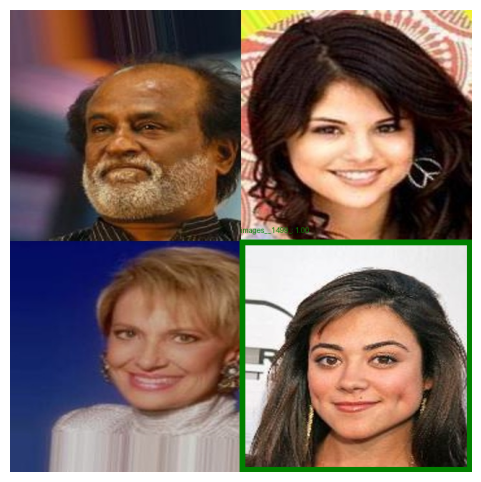

{'id': 4, 'name': 'images__1499_', 'confidence': 0.9951387643814087, 'bbox': [318.87982177734375, 318.84027099609375, 640.0, 640.0]}


In [13]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00021.jpg"
result = detect_celebrity_by_id(image_path, celebrity_id=4)

# Load image
img = Image.open(image_path).convert('RGB')

# Draw box if celebrity found
if result:
    draw = ImageDraw.Draw(img)
    x1, y1, x2, y2 = result['bbox']
    draw.rectangle([x1, y1, x2, y2], outline='green', width=8)

    label = f"{result['name']}: {result['confidence']:.2f}"
    draw.text((x1, y1-20), label, fill='green')

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

print(result)

## Testing the model for different set of grid image

In [14]:
# First, see all celebrities in the image
results = model.predict(source="/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00049.jpg", conf=0.25, verbose=False)[0]

print("All celebrities detected:")
for box in results.boxes:
    cls_idx = int(box.cls[0])
    print(f"ID: {cls_idx}, Name: {id_to_celeb[cls_idx]}")

All celebrities detected:
ID: 42, Name: images__9152_
ID: 21, Name: images__3745_
ID: 8, Name: images__2425_
ID: 20, Name: images__3699_


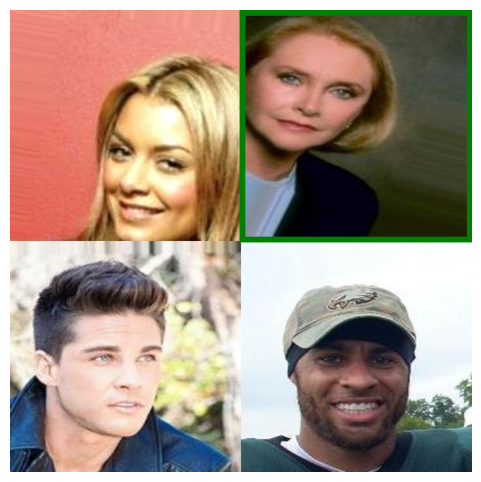

{'id': 42, 'name': 'images__9152_', 'confidence': 0.9923175573348999, 'bbox': [318.23468017578125, 0.0, 640.0, 321.3924255371094]}


In [16]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00049.jpg"
result = detect_celebrity_by_id(image_path, celebrity_id=42)

# Load image
img = Image.open(image_path).convert('RGB')

# Draw box if celebrity found
if result:
    draw = ImageDraw.Draw(img)
    x1, y1, x2, y2 = result['bbox']
    draw.rectangle([x1, y1, x2, y2], outline='green', width=8)

    label = f"{result['name']}: {result['confidence']:.2f}"
    draw.text((x1, y1-20), label, fill='green')

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

print(result)

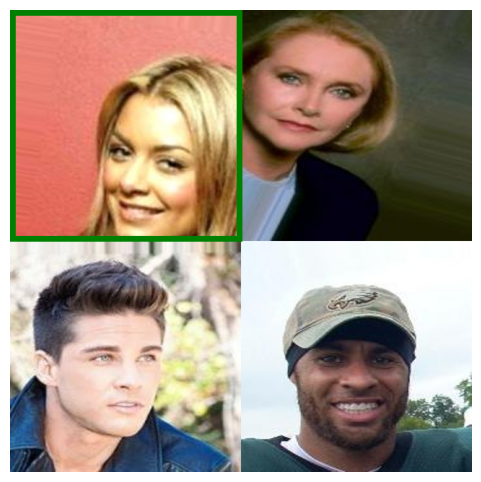

{'id': 21, 'name': 'images__3745_', 'confidence': 0.9250437021255493, 'bbox': [0.0, 0.0, 321.157958984375, 320.58062744140625]}


In [18]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

image_path = "/content/drive/MyDrive/celeba-det-grids/images/test/grid_test_00049.jpg"
result = detect_celebrity_by_id(image_path, celebrity_id=21)

# Load image
img = Image.open(image_path).convert('RGB')

# Draw box if celebrity found
if result:
    draw = ImageDraw.Draw(img)
    x1, y1, x2, y2 = result['bbox']
    draw.rectangle([x1, y1, x2, y2], outline='green', width=8)

    label = f"{result['name']}: {result['confidence']:.2f}"
    draw.text((x1, y1-20), label, fill='green')

# Display
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

print(result)

### Summary of our Milestone2

We have built a celebrity detection system that identifies and locates 46 different celebrities in multi-person images using YOLOv8. The pipeline involved creating composite grid images, training the YOLOv8 small model for 50 epochs with automated data augmentation, and achieving 84% mAP50 accuracy on the test set. The final trained model can now take any input image and return the IDs, names, confidence scores, and bounding box locations of all detected celebrities.